In [3]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import numpy as np
import pandas as pd
import time
from tensorflow.keras import datasets,models,layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.layers import SpatialDropout2D
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt

from tensorflow.keras.optimizers import SGD, Adam

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)


from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import warnings
warnings. filterwarnings('ignore')

#import the dataset
data = tf.keras.datasets.cifar10

#load the data
(x_train, y_train), (x_test, y_test) = data.load_data()

# Split the test data into validation and test datasets
# Keep test set as a completely clean hold out set

x_train, x_val, y_train, y_val = train_test_split(x_train,y_train, test_size=0.2)

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_val shape:', x_val.shape)
print('y_val shape:', y_val.shape)
print('x_test shape:', x_test.shape)
print('y_test shape:', y_test.shape)
print(x_train.shape[0], 'training samples')
print(x_val.shape[0], 'validation samples')
print(x_test.shape[0], 'test samples')

170508288/170498071 [==============================] - 3s 0us/step
x_train shape: (40000, 32, 32, 3)
y_train shape: (40000, 1)
x_val shape: (10000, 32, 32, 3)
y_val shape: (10000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)
40000 training samples
10000 validation samples
10000 test samples


## Data description and exploration 

The CIFAR-10 dataset contains 60,000 color images of 32 x 32 pixels in 3 channels divided into 10 classes. Each class contains 6,000 images. The training set contains 50,000 images, while the test sets provides 10,000 images. This image taken from the CIFAR repository ( https://www.cs.toronto.edu/~kriz/cifar.html ).

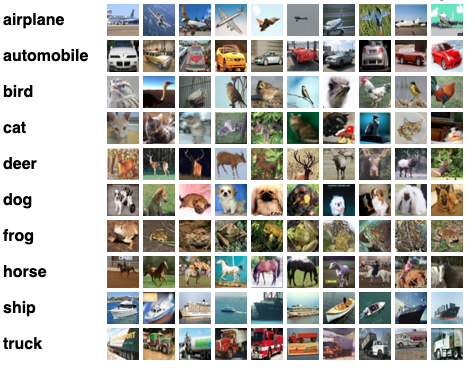

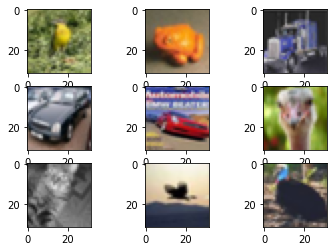

In [4]:
#View a sample of one of the images 
for x in range(9):
	# define subplot
	plt.subplot(330 + 1 + x)
	plt.imshow(x_train[x])
plt.show()

In [5]:
# Create a function to track the label names

def load_label_names():
    return ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


label_names_dict = {}

for i, label in enumerate(load_label_names()):
    label_names_dict[i] = label

labels_df = pd.DataFrame.from_dict(label_names_dict, orient='index')
labels_df


,0
0,airplane
1,automobile
2,bird
3,cat
4,deer
5,dog
6,frog
7,horse
8,ship
9,truck


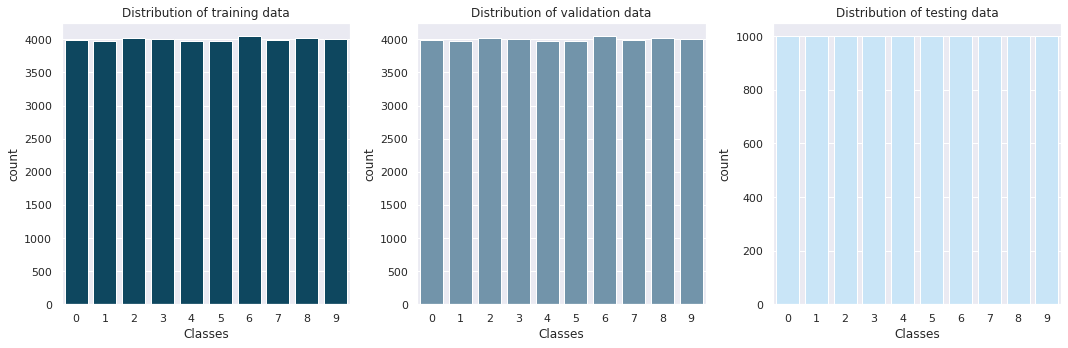

In [6]:
# check the distributions of the test and training target variables
sns.set_theme(style="darkgrid")
fig, axs = plt.subplots(1,3,figsize=(15,5)) 
# Count plot for training set
sns.countplot(y_train.ravel(), ax=axs[0], color='#004c6d')
axs[0].set_title('Distribution of training data')
axs[0].set_xlabel('Classes')
# Count plot for validation set
sns.countplot(y_train.ravel(), ax=axs[1], color='#6996b3')
axs[1].set_title('Distribution of validation data')
axs[1].set_xlabel('Classes')
# Count plot for testing set
sns.countplot(y_test.ravel(), ax=axs[2], color='#c1e7ff')
axs[2].set_title('Distribution of testing data')
axs[2].set_xlabel('Classes')
fig.tight_layout()
plt.show()

Target classes are evenly distbuted, which means 'accuracy' is a relevant metric to describe potential models.

In [7]:
# Data normalization ensures each pixel has a similar distribution, and makes an NN converge faster (Nikhil B, 2017)

x_train, x_val, x_test = x_train / 255.0, x_val / 255.0,  x_test / 255.0

#One hot encode target variables

y_train_onehot=to_categorical(y_train,10)
y_val_onehot=to_categorical(y_val,10)
y_test_onehot=to_categorical(y_test,10)


## Experimental process

 - Create a baseline architecture
 - Test various archtectures and measure each with training and validation accuracy and loss metrics
 - Augement data and measure training and validation accuracy and loss metrics
 - Use Kera Tuner to tune hyper parameters on best architecture
 - Try Transfer learning alone
 - Test the best model on holdout test set
 - Do a test prediction

In [8]:
#create dataframe to track metrics over various models

metric_df = pd.DataFrame()

#create function to draw accuracy and loss 

def plotmodelhistory(history, title = "Model"): 
    fig, axs = plt.subplots(1,2,figsize=(15,5)) 
    fig.suptitle(title, fontsize=16)
    # summarize history for accuracy
    axs[0].plot(history.history['accuracy'], color="#003f5c", label = "Training accuracy") 
    axs[0].plot(history.history['val_accuracy'], color="#bc5090", label = "Validation accuracy") 
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy') 
    axs[0].set_xlabel('Epoch')
    axs[0].legend(['train', 'validate'], loc='upper left')
    # summarize history for loss
    axs[1].plot(history.history['loss'], color="#003f5c", label = "Training loss") 
    axs[1].plot(history.history['val_loss'], color="#ff6361", label = "Validation accuracy") 
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss') 
    axs[1].set_xlabel('Epoch')
    axs[1].legend(['train', 'validate'], loc='upper left')
    plt.show()

#create model architecture function to test models

def create_model(num_conv=1, num_dense=1, model_name="Model", dropout=0, batch_norm=0, epochs=20):
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'))
    if batch_norm == 1:
        model.add(BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    if batch_norm == 1:
        model.add(BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2), padding='same'))
    
    #loop over number of Conv layer groups
    for i in range(num_conv):
        model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
        if batch_norm == 1:
            model.add(BatchNormalization())
        model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
        if batch_norm == 1:
            model.add(BatchNormalization())
        model.add(layers.MaxPool2D(pool_size=(2,2), padding='same'))
        
    #add dropout layer if set as a parameter
    if dropout > 0:
        model.add(Dropout(dropout))
        
        
    # flatten the model before putting into dense layers
    model.add(layers.Flatten())
    
    #loop over number of dense layers
    for i in range(num_dense):
        model.add(layers.Dense(128,activation='relu'))
        
    # Output layer for model
    model.add(layers.Dense(10, activation='softmax'))

    #compile the model

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    #fit the model

    history=model.fit(x_train,y_train_onehot,epochs=epochs,validation_data=(x_val,y_val_onehot), verbose=0 ,shuffle=True)
    
    #Add metrics to dictionary to store
    metric_dict = {'Model': model_name, 
                    'Train Accuracy': history.history['accuracy'][-1],
                    'Validation Accuracy': history.history['val_accuracy'][-1], 
                    'Train Loss': history.history['loss'][-1],
                    'Validation Loss': history.history['val_loss'][-1],

                    }
    
    return model, history, metric_dict

## Baseline Model: 2 Conv, 1 max pool, 1 dense output

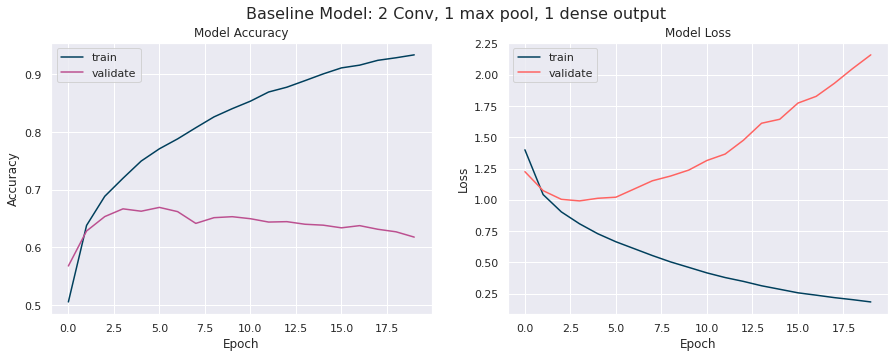

Time elapsed: 146.69564938545227


,Model,Train Accuracy,Validation Accuracy,Train Loss,Validation Loss
0,"Baseline Model: 2 Conv, 1 max pool, 1 dense output",0.933525,0.6176,0.183276,2.158859


In [9]:
#baseline model
start = time.time()
model_name = "Baseline Model: 2 Conv, 1 max pool, 1 dense output"
model, history, metric_dict = create_model(num_conv=0, num_dense=0, model_name=model_name)
plotmodelhistory(history, title = model_name)
metric_df = metric_df.append(metric_dict, ignore_index = True)
end = time.time()
print ("Time elapsed:", end - start)
metric_df



In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 10)                81930     
                                                                 
Total params: 92,074
Trainable params: 92,074
Non-trainable params: 0
____________________________________________________

## Model 1: 4 Conv, 2 max pool, 1 dense output

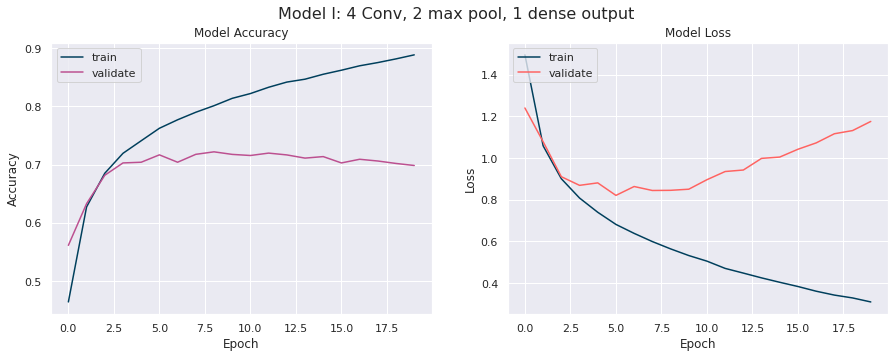

Time elapsed: 101.59223055839539


,Model,Train Accuracy,Validation Accuracy,Train Loss,Validation Loss
0,"Baseline Model: 2 Conv, 1 max pool, 1 dense output",0.933525,0.6176,0.183276,2.158859
1,"Model l: 4 Conv, 2 max pool, 1 dense output",0.888850,0.6985,0.309570,1.175378


In [11]:
#Model 1:
start = time.time()
model_name = "Model l: 4 Conv, 2 max pool, 1 dense output"
model, history, metric_dict = create_model(num_conv=1, num_dense=0, model_name=model_name)
plotmodelhistory(history, title = model_name)
metric_df = metric_df.append(metric_dict, ignore_index = True)
end = time.time()
print ("Time elapsed:", end - start)
metric_df


Adding 2 convolusion layers has increased the validation accuracy. The extra layers have increased the complexity of the model allowing it to pick up low level features in the images better.

## Model 2: 6 Conv, 3 max pool, 1 dense output

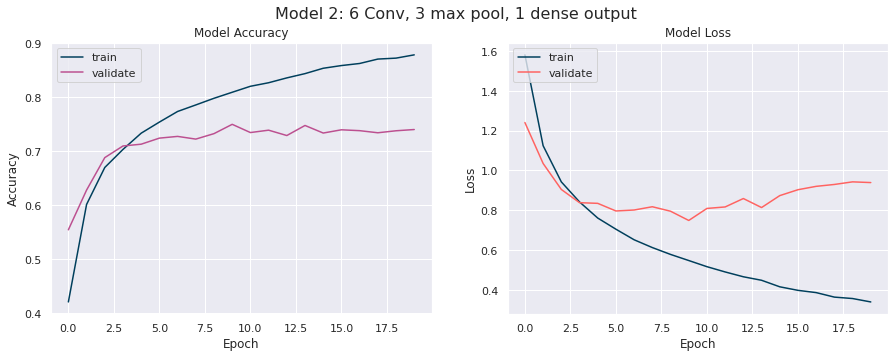

Time elapsed: 143.63680338859558


,Model,Train Accuracy,Validation Accuracy,Train Loss,Validation Loss
0,"Baseline Model: 2 Conv, 1 max pool, 1 dense output",0.933525,0.6176,0.183276,2.158859
1,"Model l: 4 Conv, 2 max pool, 1 dense output",0.888850,0.6985,0.309570,1.175378
2,"Model 2: 6 Conv, 3 max pool, 1 dense output",0.877775,0.7398,0.339521,0.939233


In [12]:
#Model 2: 
start = time.time()
model_name = "Model 2: 6 Conv, 3 max pool, 1 dense output"
model2, history2, metric_dict = create_model(num_conv=2, num_dense=0, model_name=model_name)
plotmodelhistory(history2, title = model_name)
metric_df = metric_df.append(metric_dict, ignore_index = True)
end = time.time()
print ("Time elapsed:", end - start)
metric_df


Adding an extra 2 convolusion layers has again increased the validation accuracy and lowered the overfitting, at the expense of a small drop in training accuracy. Adding more CNN layers risks making the model too complex.

## Model 3: 6 Conv, 3 max pool, 1, dense layer,  1 dense output

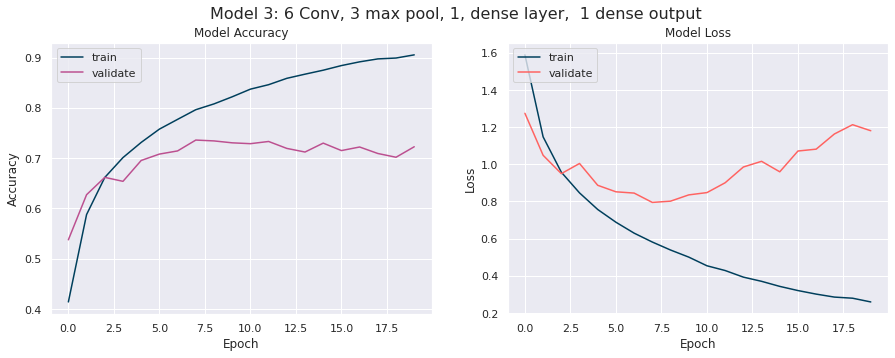

Time elapsed: 143.69713163375854


,Model,Train Accuracy,Validation Accuracy,Train Loss,Validation Loss
0,"Baseline Model: 2 Conv, 1 max pool, 1 dense output",0.933525,0.6176,0.183276,2.158859
1,"Model l: 4 Conv, 2 max pool, 1 dense output",0.888850,0.6985,0.309570,1.175378
2,"Model 2: 6 Conv, 3 max pool, 1 dense output",0.877775,0.7398,0.339521,0.939233
3,"Model 3: 6 Conv, 3 max pool, 1, dense layer, 1 dense output",0.905300,0.7225,0.259209,1.180293


In [13]:
#Model 3: 
start = time.time()
model_name = "Model 3: 6 Conv, 3 max pool, 1, dense layer,  1 dense output"
model3, history3, metric_dict = create_model(num_conv=2, num_dense=1, model_name=model_name)
plotmodelhistory(history3, title = model_name)
metric_df = metric_df.append(metric_dict, ignore_index = True)
end = time.time()
print ("Time elapsed:", end - start)
metric_df


Adding a dense layer has dropped the validation accuracy, this is because the model is now overfitting. The model may now benefit from various regularization techiniques.

## Model 4: 6 Conv, 3 max pool, 1 dropout,  1 dense output

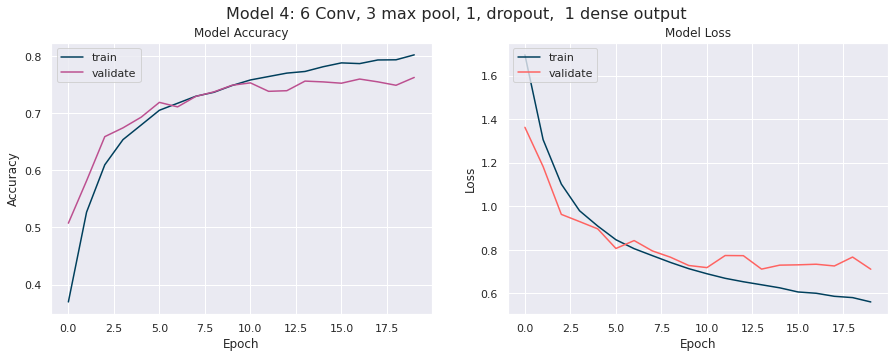

Time elapsed: 143.72490906715393


,Model,Train Accuracy,Validation Accuracy,Train Loss,Validation Loss
0,"Baseline Model: 2 Conv, 1 max pool, 1 dense output",0.933525,0.6176,0.183276,2.158859
1,"Model l: 4 Conv, 2 max pool, 1 dense output",0.888850,0.6985,0.309570,1.175378
2,"Model 2: 6 Conv, 3 max pool, 1 dense output",0.877775,0.7398,0.339521,0.939233
3,"Model 3: 6 Conv, 3 max pool, 1, dense layer, 1 dense output",0.905300,0.7225,0.259209,1.180293
4,"Model 4: 6 Conv, 3 max pool, 1, dropout, 1 dense output",0.801825,0.7623,0.561029,0.711217


In [14]:
#Model 4: 
start = time.time()
model_name = "Model 4: 6 Conv, 3 max pool, 1, dropout,  1 dense output"
model4, history4, metric_dict = create_model(num_conv=2, num_dense=0, model_name=model_name, dropout=0.4)
plotmodelhistory(history4, title = model_name)
metric_df = metric_df.append(metric_dict, ignore_index = True)
end = time.time()
print ("Time elapsed:", end - start)
metric_df


Adding a dropout layer has drastically brought the curves closer together, but at the expense of training accuracy. Validation accuracy has increased. Running the model over more epochs may still increase the accuracy as both curves do not seem to have leveled out yet. I will try to add batch normalization between layers, this has the effect of stabilizing the learning process and dramatically reducing the number of training epochs(https://www.facebook.com/jason.brownlee.39, 2019) and reducing chances of suffering from the vanishing gradient problem.

## Model 5: 6 Conv, 3 max pool, 1, dense layer,1 dropout, batch norm between layers

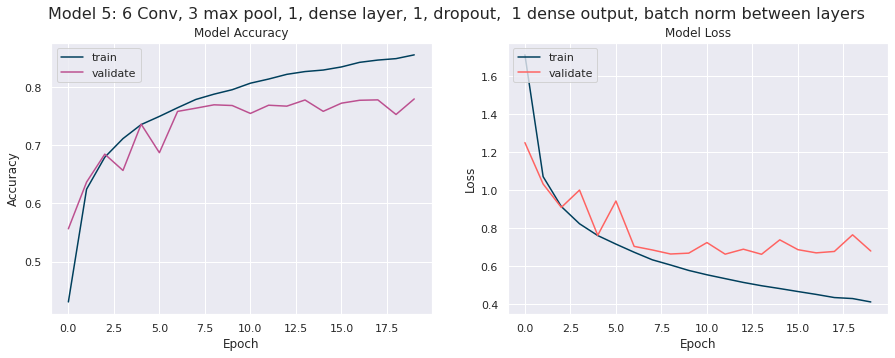

Time elapsed: 144.2300522327423


,Model,Train Accuracy,Validation Accuracy,Train Loss,Validation Loss
0,"Baseline Model: 2 Conv, 1 max pool, 1 dense output",0.933525,0.6176,0.183276,2.158859
1,"Model l: 4 Conv, 2 max pool, 1 dense output",0.888850,0.6985,0.309570,1.175378
2,"Model 2: 6 Conv, 3 max pool, 1 dense output",0.877775,0.7398,0.339521,0.939233
3,"Model 3: 6 Conv, 3 max pool, 1, dense layer, 1 dense output",0.905300,0.7225,0.259209,1.180293
4,"Model 4: 6 Conv, 3 max pool, 1, dropout, 1 dense output",0.801825,0.7623,0.561029,0.711217
5,"Model 5: 6 Conv, 3 max pool, 1, dense layer, 1, dropout, 1 dense output, batch norm between layers",0.855175,0.7795,0.413086,0.680963


In [15]:
#Model 5: 
start = time.time()
model_name = "Model 5: 6 Conv, 3 max pool, 1, dense layer, 1, dropout,  1 dense output, batch norm between layers"
model5, history5, metric_dict = create_model(num_conv=2, num_dense=0, model_name=model_name, dropout=0.4, batch_norm=1)
plotmodelhistory(history5, title = model_name)
metric_df = metric_df.append(metric_dict, ignore_index = True)
end = time.time()
print ("Time elapsed:", end - start)
metric_df


In [16]:
metric_df

,Model,Train Accuracy,Validation Accuracy,Train Loss,Validation Loss
0,"Baseline Model: 2 Conv, 1 max pool, 1 dense output",0.933525,0.6176,0.183276,2.158859
1,"Model l: 4 Conv, 2 max pool, 1 dense output",0.888850,0.6985,0.309570,1.175378
2,"Model 2: 6 Conv, 3 max pool, 1 dense output",0.877775,0.7398,0.339521,0.939233
3,"Model 3: 6 Conv, 3 max pool, 1, dense layer, 1 dense output",0.905300,0.7225,0.259209,1.180293
4,"Model 4: 6 Conv, 3 max pool, 1, dropout, 1 dense output",0.801825,0.7623,0.561029,0.711217
5,"Model 5: 6 Conv, 3 max pool, 1, dense layer, 1, dropout, 1 dense output, batch norm between layers",0.855175,0.7795,0.413086,0.680963


Adding the batch normalisation layers has drastically increased training and validation accuracy. The model is generalising well. I will use this base architecture going forward and now focus on augmenting data and hyper parameter tuning. I will try more epochs to see if this helps.

## Model 6: 6 Conv, 3 max pool, 1, dense layer, 1, dropout, 1 dense output, batch norm between layers, 50 epochs

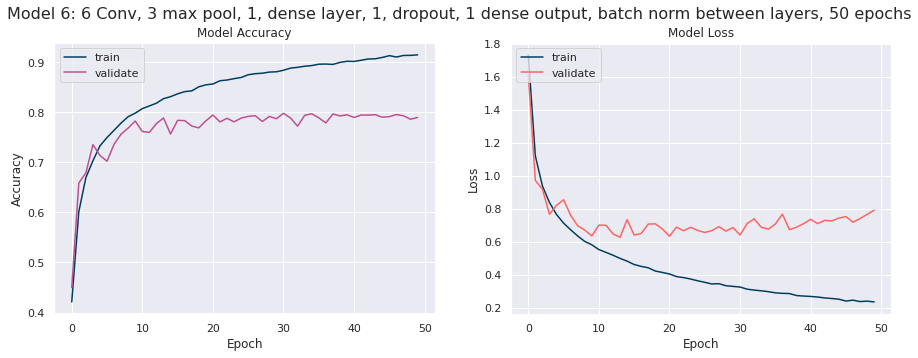

Time elapsed: 384.16242599487305


,Model,Train Accuracy,Validation Accuracy,Train Loss,Validation Loss
0,"Baseline Model: 2 Conv, 1 max pool, 1 dense output",0.933525,0.6176,0.183276,2.158859
1,"Model l: 4 Conv, 2 max pool, 1 dense output",0.888850,0.6985,0.309570,1.175378
2,"Model 2: 6 Conv, 3 max pool, 1 dense output",0.877775,0.7398,0.339521,0.939233
3,"Model 3: 6 Conv, 3 max pool, 1, dense layer, 1 dense output",0.905300,0.7225,0.259209,1.180293
4,"Model 4: 6 Conv, 3 max pool, 1, dropout, 1 dense output",0.801825,0.7623,0.561029,0.711217
5,"Model 5: 6 Conv, 3 max pool, 1, dense layer, 1, dropout, 1 dense output, batch norm between layers",0.855175,0.7795,0.413086,0.680963
6,"Model 6: 6 Conv, 3 max pool, 1, dense layer, 1, dropout, 1 dense output, batch norm between layers, 50 epochs",0.914900,0.7898,0.234914,0.791662


In [17]:
#Model 6: 
start = time.time()
model_name = "Model 6: 6 Conv, 3 max pool, 1, dense layer, 1, dropout, 1 dense output, batch norm between layers, 50 epochs"
model6, history6, metric_dict = create_model(num_conv=2, num_dense=0, model_name=model_name, dropout=0.4, batch_norm=1, epochs=50)
plotmodelhistory(history6, title = model_name)
metric_df = metric_df.append(metric_dict, ignore_index = True)
end = time.time()
print ("Time elapsed:", end - start)
metric_df

In [18]:
model6.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_31 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 16, 16, 32)       0         
 g2D)                                                            
                                                      

Data augmentations often helps models to help generalize on unseen data.

## Add data augmentation

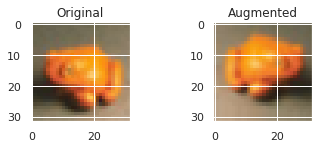

In [9]:
# Data augmentation

width_shift = 3/32
height_shift = 3/32
flip = True

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

it = datagen.flow(x_train, y_train, shuffle=False)
batch_images, batch_labels = next(it)

#Show orginal image and the same image after augmentation

plt.subplot(221)
plt.title("Original")
plt.imshow(x_train[1])
plt.subplot(222)
plt.title("Augmented")
plt.imshow(batch_images[1])          
plt.show()


In [20]:
#Create model to use to try and improve from model 5 with data augmentation

def create_model_version_2(model_name='Model', dropout=0.4, epochs=50, batch_size=64):
    model = Sequential()
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2), padding='same'))

    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2), padding='same'))
    
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2), padding='same'))
        
    model.add(Dropout(dropout)) 
        
    # flatten the model before putting into dense layers
    model.add(layers.Flatten())
        
    # Output layer for model
    model.add(layers.Dense(10, activation='softmax'))
    


    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    #fit the model

    history=model.fit(datagen.flow(x_train,y_train_onehot, batch_size=batch_size),steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,validation_data=(x_val,y_val_onehot), verbose=0 ,shuffle=True)
    
    #Add metrics to dictionary to store
    metric_dict = {'Model': model_name, 
                    'Train Accuracy': history.history['accuracy'][-1],
                    'Validation Accuracy': history.history['val_accuracy'][-1], 
                    'Train Loss': history.history['loss'][-1],
                    'Validation Loss': history.history['val_loss'][-1],

                    }
    
    return model , history, metric_dict

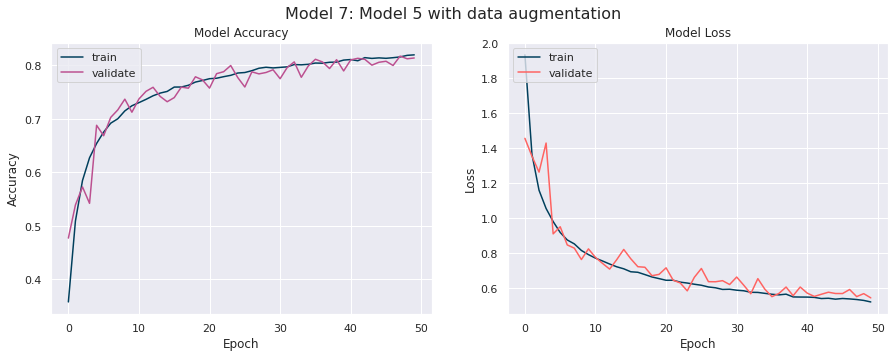

Time elapsed: 906.7195301055908


,Model,Train Accuracy,Validation Accuracy,Train Loss,Validation Loss
0,"Baseline Model: 2 Conv, 1 max pool, 1 dense output",0.933525,0.6176,0.183276,2.158859
1,"Model l: 4 Conv, 2 max pool, 1 dense output",0.888850,0.6985,0.309570,1.175378
2,"Model 2: 6 Conv, 3 max pool, 1 dense output",0.877775,0.7398,0.339521,0.939233
3,"Model 3: 6 Conv, 3 max pool, 1, dense layer, 1 dense output",0.905300,0.7225,0.259209,1.180293
4,"Model 4: 6 Conv, 3 max pool, 1, dropout, 1 dense output",0.801825,0.7623,0.561029,0.711217
5,"Model 5: 6 Conv, 3 max pool, 1, dense layer, 1, dropout, 1 dense output, batch norm between layers",0.855175,0.7795,0.413086,0.680963
6,"Model 6: 6 Conv, 3 max pool, 1, dense layer, 1, dropout, 1 dense output, batch norm between layers, 50 epochs",0.914900,0.7898,0.234914,0.791662
7,Model 7: Model 5 with data augmentation,0.819450,0.8136,0.521565,0.544821


In [21]:
#Model 7: 
start = time.time()
model_name = "Model 7: Model 5 with data augmentation "
model7, history7, metric_dict, = create_model_version_2(model_name=model_name)
plotmodelhistory(history7, title = model_name)
metric_df = metric_df.append(metric_dict, ignore_index = True)

end = time.time()
print ("Time elapsed:", end - start)

metric_df

Augementation has helps with generalisation and increased the validation at the expense of training accuracy.

## Keras Tuner


Keras tuner is a built in tuner from Keras to assist in finding the most efficient hyper parameters. I will use Random search to try and see if i can find optimal values for filters, activation function, learning rate and dropout.


In [22]:
# Prepare function to run keras tuner to find best numbers for the CNN filters. Due to computational speeds i have limited the search for filters and the one neuron on the dense layer

def create_model_tuner(hp):
    filters1 = hp.Int(name = 'filters1', min_value = 16, max_value = 64, step=16)
    filters2 = hp.Int(name = 'filters2', min_value = 16, max_value = 64, step=16)
    filters3 = hp.Int(name = 'filters3', min_value = 16, max_value = 64, step=16)
    filters4 = hp.Int(name = 'filters4', min_value = 16, max_value = 64, step=16)
    filters5 = hp.Int(name = 'filters5', min_value = 16, max_value = 64, step=16)
    filters6 = hp.Int(name = 'filters6', min_value = 16, max_value = 64, step=16)
    dropout1 = hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)
    dropout2 = hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)
    dropout3 = hp.Float('dropout', 0, 0.5, step=0.1, default=0.5)
    activation1 = activation=hp.Choice('activation', ['relu', 'elu'])
    activation2 = activation=hp.Choice('activation', ['relu', 'elu'])
    activation3 = activation=hp.Choice('activation', ['relu', 'elu'])
    activation4 = activation=hp.Choice('activation', ['relu', 'elu'])
    activation5 = activation=hp.Choice('activation', ['relu', 'elu'])
    activation6 = activation=hp.Choice('activation', ['relu', 'elu'])
    lr = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model = Sequential()
    model.add(layers.Conv2D(filters=filters1, kernel_size=(3, 3), activation=activation1, input_shape=(32, 32, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(layers.Conv2D(filters=filters2, kernel_size=(3, 3), activation=activation2, padding='same'))
    model.add(BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(dropout1))

    model.add(layers.Conv2D(filters=filters3, kernel_size=(3, 3), activation=activation3, padding='same'))
    model.add(BatchNormalization())
    model.add(layers.Conv2D(filters=filters4, kernel_size=(3, 3), activation=activation4, padding='same'))
    model.add(BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2), padding='same'))
    model.add(Dropout(dropout2))
    
    model.add(layers.Conv2D(filters=filters5, kernel_size=(3, 3), activation=activation5, padding='same'))
    model.add(BatchNormalization())
    model.add(layers.Conv2D(filters=filters6, kernel_size=(3, 3), activation=activation6, padding='same'))
    model.add(BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2), padding='same'))
        
    model.add(Dropout(dropout3)) 
        
    # flatten the model before putting into dense layers
    model.add(layers.Flatten())
        
    # Output layer for model
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [23]:
# Run the tuner

tuner = kt.RandomSearch(create_model_tuner,
                    objective='val_accuracy',
                    max_trials = 10,
                    overwrite=True
                    )

tuner.search(datagen.flow(x_train,y_train_onehot, batch_size=64), epochs=20, validation_data=(x_val, y_val_onehot))
best_model = tuner.get_best_models()[0]

Trial 10 Complete [00h 07m 22s]
val_accuracy: 0.7669000029563904

Best val_accuracy So Far: 0.808899998664856
Total elapsed time: 01h 10m 55s
INFO:tensorflow:Oracle triggered exit


In [24]:
print(tuner.get_best_hyperparameters(1)[0].values)

{'filters1': 48, 'filters2': 32, 'filters3': 48, 'filters4': 64, 'filters5': 32, 'filters6': 64, 'dropout': 0.1, 'activation': 'elu', 'learning_rate': 0.001}


## Transfer learning


Resnet 50 is a pretrained model trained on over a million images from the Imagenet database and is 50 layers deep. It can classify images into over 1000 categories. Transfer learning allows us to 'piggy back' of adanced models with weights already calculated.



In [38]:
from tensorflow.keras.applications import ResNet50
base = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

for layer in base.layers[:143]:
        layer.trainable = False

def create_model_Resnet(epochs = 50, batch_size=100, model_name='Resnet'):
  
    model = Sequential()

    model.add(base)
    model.add(layers.Flatten())
    model.add(Dense(2048,activation=('relu'),input_dim=2048))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(10, activation='softmax'))


    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
    
    history=model.fit(x_train,y_train_onehot,steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,validation_data=(x_val,y_val_onehot), verbose=0 ,shuffle=True)
    
    #Add metrics to dictionary to store
    metric_dict = {'Model': model_name, 
                    'Train Accuracy': history.history['accuracy'][-1],
                    'Validation Accuracy': history.history['val_accuracy'][-1], 
                    'Train Loss': history.history['loss'][-1],
                    'Validation Loss': history.history['val_loss'][-1],

                    }
    
    return model , history, metric_dict


    

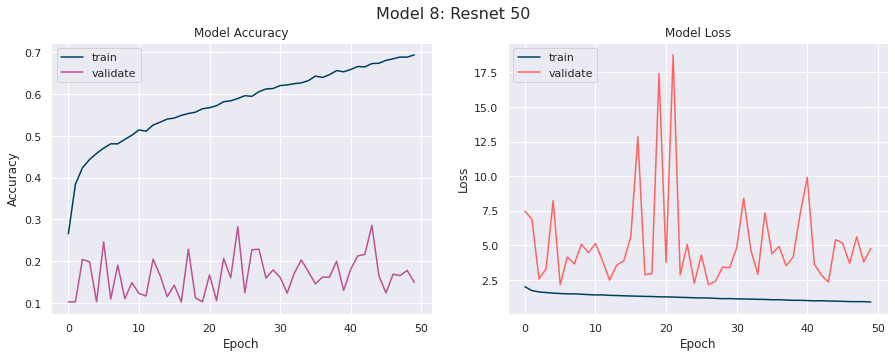

Time elapsed: 867.1360042095184


,Model,Train Accuracy,Validation Accuracy,Train Loss,Validation Loss
0,Model 8: Resnet 50,0.098300,0.0999,2.303821,2.304155
1,Model Final: Final model with hyperparameters,0.882800,0.8390,0.339289,0.534065
2,Model 8: Resnet 50,0.098825,0.1004,2.303958,2.304018
3,Model 8: Resnet 50,0.102525,0.0999,2.303889,2.303071
4,Model 8: Resnet 50,0.098225,0.1031,2.303819,2.303896
5,Model 8: Resnet 50,0.299400,0.2873,1.838301,1.886809
6,Model 8: Resnet 50,0.100025,0.0980,2.303426,2.303025
7,Model 8: Resnet 50,0.622375,0.1546,1.135490,7.949788
8,Model 8: Resnet 50,0.693775,0.1494,0.920559,4.772602


In [39]:
#Model 8: 

start = time.time()
model_name = "Model 8: Resnet 50 "
model8, history8, metric_dict, = create_model_Resnet(model_name=model_name)
plotmodelhistory(history8, title = model_name)
metric_df = metric_df.append(metric_dict, ignore_index = True)

end = time.time()
print ("Time elapsed:", end - start)

metric_df

## Create final model with all hyperparamenters and architecture adjustments

After tuning and testing the models the final model is captured below:

In [12]:
def create_final_model(model_name='Model', dropout=0.4, epochs=100, batch_size=64):
    model = Sequential()
    model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(layers.Conv2D(48, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2), padding='same'))

    model.add(layers.Conv2D(48, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(layers.Conv2D(48, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2), padding='same'))
    
    model.add(layers.Conv2D(48, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(layers.Conv2D(48, kernel_size=(3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(layers.MaxPool2D(pool_size=(2,2), padding='same')) 
        
    # flatten the model before putting into dense layers
    model.add(layers.Flatten())
        
    # Output layer for model
    model.add(layers.Dense(10, activation='softmax'))
    


    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])

    #fit the model with augmented data

    history=model.fit(datagen.flow(x_train,y_train_onehot, batch_size=batch_size),steps_per_epoch=x_train.shape[0] // batch_size,epochs=epochs,validation_data=(x_val,y_val_onehot), verbose=0 ,shuffle=True)
    
    #Add metrics to dictionary to store
    metric_dict = {'Model': model_name, 
                    'Train Accuracy': history.history['accuracy'][-1],
                    'Validation Accuracy': history.history['val_accuracy'][-1], 
                    'Train Loss': history.history['loss'][-1],
                    'Validation Loss': history.history['val_loss'][-1],

                    }
    
    return model , history, metric_dict

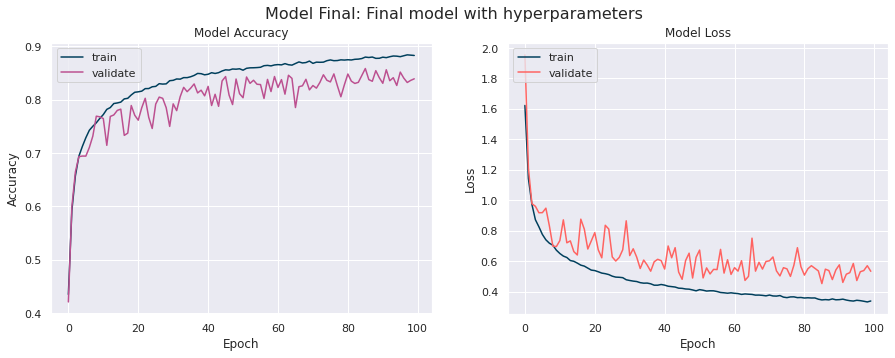

Time elapsed: 1898.8502368927002


,Model,Train Accuracy,Validation Accuracy,Train Loss,Validation Loss
0,Model 8: Resnet 50,0.0983,0.0999,2.303821,2.304155
1,Model Final: Final model with hyperparameters,0.8828,0.8390,0.339289,0.534065


In [13]:
#Model Final: 
start = time.time()
model_name = "Model Final: Final model with hyperparameters "
model9, history9, metric_dict, = create_final_model(model_name=model_name)
plotmodelhistory(history9, title = model_name)
metric_df = metric_df.append(metric_dict, ignore_index = True)

end = time.time()
print ("Time elapsed:", end - start)

metric_df

## Evaluate final model against the test set

In [14]:
testLoss, testAccuracy = model9.evaluate(x_test, y_test_onehot)

print('Model Loss is {}'.format(testLoss))
print('Model Accuracy is {}'.format(testAccuracy))

313/313 [==============================] - 1s 4ms/step - loss: 0.5348 - accuracy: 0.8428
Model Loss is 0.5347744822502136
Model Accuracy is 0.8428000211715698


In [15]:
def display_images(digits, predictions, labels, title):

  n = 10

  indexes = np.random.choice(len(predictions), size=n)
  n_digits = digits[indexes]
  n_predictions = predictions[indexes]
  n_predictions = n_predictions.reshape((n,))
  n_labels = labels[indexes]
 
  fig = plt.figure(figsize=(20, 4))
  plt.title(title)
  plt.yticks([])
  plt.xticks([])

  for i in range(10):
    ax = fig.add_subplot(1, 10, i+1)
    class_index = n_predictions[i]
    
    plt.xlabel(classes[class_index])
    plt.xticks([])
    plt.yticks([])
    plt.imshow(n_digits[i])


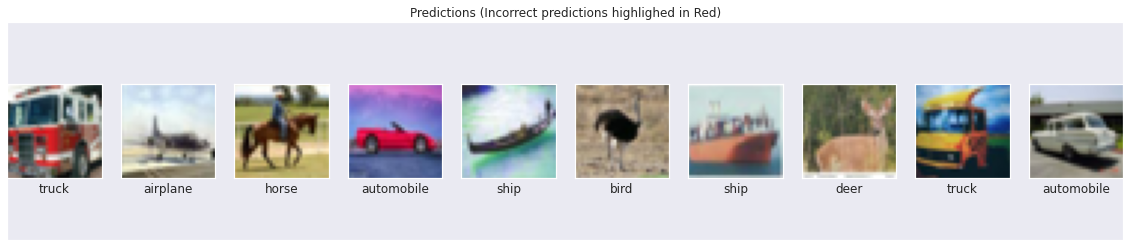

In [16]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

prob = model9.predict(x_test, batch_size=64)
prob = np.argmax(prob, axis = 1)

display_images(x_test, prob, y_test, "Predictions (Incorrect predictions highlighed in Red)")